In [1]:
import json
import os

%load_ext dotenv
%dotenv

# f = open("authPaper.json")
# auth = json.load(f)

In [2]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
# BASE_URL = "https://paper-api.alpaca.markets"
# API_KEY = auth['ID']
# SECRET_KEY = auth['Secret']

In [3]:
api = tradeapi.REST(key_id= os.getenv('API_KEY'), secret_key=os.getenv('SECRET_KEY'), base_url=os.getenv('APCA_API_BASE_URL'), api_version='v2')

In [4]:
df_apple = api.get_bars("AAPL", TimeFrame.Day, "2020-09-01", "2022-07-02", adjustment='raw').df

<AxesSubplot:xlabel='timestamp'>

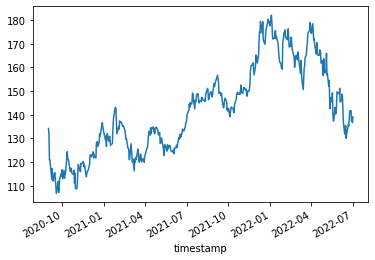

In [5]:
df_apple['close'].plot()

In [6]:
# importing forecasting libraries
import pmdarima as pm
import numpy as npf
import matplotlib.pyplot as plt
import seaborn as sn

In [7]:
arima_model = pm.auto_arima(df_apple['close'], seasonal = False)

# Random Walk (Useless)
A random walk does not help predict the next values only that the variance will increase... lame <br>
This is for predictions involving the closing cost

In [8]:
arima_model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Forecasting Volume

We can see that volume is dependant on on previous lag with a ar and ma term.

In [9]:
arima_model = pm.auto_arima(df_apple['volume'], seasonal = False)

arima_model

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Correlation plot

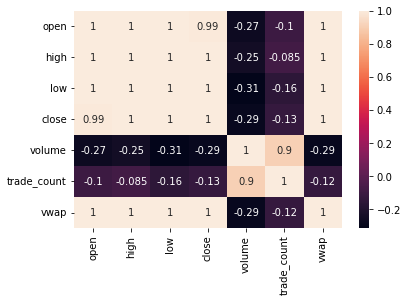

In [10]:
corrMatrix = df_apple.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [11]:
# building linear model
import statsmodels.api as sm
import math
from scipy import stats
from scipy import special
import pandas as pd
import numpy as np

## creating function to automate linear modeling with variables using forecasted predictors

In [12]:
# Setting to be function variables
stock = "AAPL"
test_set_length = 30

In [13]:
df_bars = api.get_bars(stock, TimeFrame.Day, "2020-09-01", "2022-07-02", adjustment='raw').df

df_bars

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2020-09-01 04:00:00+00:00,132.91,134.800,130.5300,134.18,152880540,1494300,132.851768
2020-09-02 04:00:00+00:00,137.58,137.980,127.0000,131.40,200393336,1843498,131.616730
2020-09-03 04:00:00+00:00,126.97,128.840,120.5000,120.88,257604126,2360769,123.526182
2020-09-04 04:00:00+00:00,120.00,123.700,110.8900,120.96,332632509,2967070,117.943903
2020-09-08 04:00:00+00:00,113.74,118.990,112.6800,112.82,231598461,2003683,115.392545
...,...,...,...,...,...,...,...
2022-06-27 04:00:00+00:00,142.70,143.490,140.9650,141.66,73357944,516181,142.026287
2022-06-28 04:00:00+00:00,142.10,143.422,137.3250,137.44,67315336,546241,139.375156
2022-06-29 04:00:00+00:00,137.44,140.670,136.6700,139.23,66354959,572556,139.273624


Uses BoxCox tranformation to get closer to the norality assumption

In [14]:
transform_variables = ['close', 'volume', 'trade_count']
lambda_fitted = [None] * len(transform_variables)
# transform training data & save lambda value
for ind, variables in enumerate(transform_variables):
    transformed_data, fitted_lambda = stats.boxcox(df_bars[variables])
    
    df_bars[variables] = transformed_data
    
    lambda_fitted[ind] = fitted_lambda

Training and test setting

In [15]:
df_bars_train = df_bars[:-test_set_length]
df_bars_test = df_bars[-test_set_length:]

Fits a linear model using volume and trade_count as predictors with close price as the target

In [16]:
# building linear model
predictors = df_bars[['volume', 'trade_count']]
predictors = sm.add_constant(predictors)

fitted_linear = sm.OLS(df_bars['close'], predictors).fit()

fitted_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     80.17
Date:                Sun, 03 Jul 2022   Prob (F-statistic):           1.38e-30
Time:                        20:02:06   Log-Likelihood:                 1087.6
No. Observations:                 462   AIC:                            -2169.
Df Residuals:                     459   BIC:                            -2157.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4845.5858    385.501     12.570      0.000    4088.020    5603.152
volume      -2955.9388    236.820    -12.482      0.000   -3421.326   -2490.552
trade_count   271.3561     25.577     10.609      0.000     221.093     321.619
==============================================================================
Omnibus:                       11.647   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                8.741
Skew:                           0.231   Prob(JB):                       0.0126
Kurtosis:                       2.510   Cond. No.                     1.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

adds constant to the test set and then gets the predicted variables from the fitted linear model

In [17]:
new_data_lm = sm.add_constant(df_bars_test[['volume', 'trade_count']])

test_pred_lm = fitted_linear.predict(new_data_lm)

# getting mae for linear model will be used to set trigger for buy and cell
np.mean(np.abs(special.inv_boxcox(test_pred_lm, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0])))

7.786466039451662

forecasting the predictor variables

In [18]:
arima_volume_model = pm.auto_arima(df_bars_train['volume'], seasonal = False)
arima_trade_model = pm.auto_arima(df_bars_train['trade_count'], seasonal = False)

C:\Users\jmhea\anaconda3\envs\outback\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


goes through a loop to get a one step ahead forecast adding another observation of data to the original forecasted models <br>
and then saves the forecast to test lists

In [19]:
test_volume_error = []
test_trade_error = []

for i in range((test_set_length), 0, -1):
    
    tmp_volume_model = arima_volume_model
    tmp_trade_model = arima_trade_model

    if (i == 30):
        
        test_volume_error.append(tmp_volume_model.predict(n_periods = 1)[0])
        
        test_trade_error.append(arima_trade_model.predict(n_periods = 1)[0])
    else:
        tmp_volume_model.update(df_bars_test[i:].volume)
        
        test_volume_error.append(tmp_volume_model.predict(n_periods = 1)[0])
        
        tmp_trade_model.update(df_bars_test[i:].trade_count)
        
        test_trade_error.append(tmp_trade_model.predict(n_periods = 1)[0])

Getting the accuracy measures from the forecasts

In [20]:
# getting mae for volume one step ahead forecasts
np.mean(np.abs(special.inv_boxcox(test_volume_error, lambda_fitted[1]) - special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1])))

18217674.054706924

In [21]:
# getting mape for volume
np.mean(np.abs(special.inv_boxcox(test_volume_error, lambda_fitted[1]) - special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1]))/special.inv_boxcox(df_bars_test['volume'], lambda_fitted[1]))

0.17864370659516568

In [22]:
# getting mae for volume one step ahead for trade_count
np.mean(np.abs(special.inv_boxcox(test_trade_error, lambda_fitted[2]) - special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2])))

128508.27579749092

In [23]:
# mape for trade_count
np.mean(np.abs(special.inv_boxcox(test_trade_error, lambda_fitted[2]) - special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2]))/ special.inv_boxcox(df_bars_test['trade_count'], lambda_fitted[2]))

0.16268821950790816

Using the forecasted predictor values to get estimated target variables and viewing the accuracy

In [24]:
# instead of using the actual testset to test linear model use the forecasted
df_new_forecast = pd.DataFrame({'volume': test_volume_error, 'trade_count': test_trade_error})
# if mape is smaller than .5, we are acurate more than 50% of the time...

df_new_forecast = sm.add_constant(df_new_forecast)

pred_lm_forecast = fitted_linear.predict(df_new_forecast)

In [25]:
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True)))

8.072726138762716

In [26]:
# getting standard deviation to see the spread of the data
1.96*np.std(special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]))

11.304526606504057

In [27]:
# mape for the forecasted new dataset using one step ahead forecasts
# getting 10% is pretty great from forecast to a linear model.. 
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, lambda_fitted[0]) - special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True))/special.inv_boxcox(df_bars_test['close'], lambda_fitted[0]).reset_index(drop = True))

0.05891627067337321

# Using PCA and applied previous method to predict closing price

In [28]:
# Calls libraries used for pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [29]:
# 50 top stocks
stock_list = ['DIDI', 'AMD', 'AAPL', 'AMZN', 'CCL', 'NIO', 'F', 'BBD', 'ITUB', \
             'ABEV', 'BABA', 'NVDA', 'NOK', 'AAL', 'DOCU', 'SNAP', 'PCG', 'SOFI', \
             'SWN', 'INTC', 'AUY', 'CERN', 'PBR', 'T', 'TSLA', 'GRAB', 'NCLH', \
             'NU', 'MSFT', 'NLY', 'PLTR', 'UBER', 'WFC', 'META', 'XOM', 'MU', \
             'OXY', 'AMC', 'WBD', 'RIG', 'CS', 'OPEN', 'RBLX', 'PFE', 'PDD', \
             'FCX', 'GFI', 'DKNG']

In [30]:
df_group_bars = pd.DataFrame()

# runs through list of stocks and pulls a given stock and concatinates that onto a main df. it also creates a stock column,
# which is just the stock name
for stocks in stock_list:
    
    if (len(df_group_bars) == 0):
        
        df_group_bars = api.get_bars(stocks, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df
        
        df_group_bars['stock'] = stocks
    else:
    
        df_temp_stock = api.get_bars(stocks, TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df
        
        df_temp_stock['stock'] = stocks
        
        df_group_bars = pd.concat([df_group_bars, df_temp_stock])

In [31]:
# Sets up for data pivot to wider
df_group_bars['datetime'] = df_group_bars.index
df_group_bars['datetime'] = pd.to_datetime(df_group_bars['datetime'])
# df_group_bars.pivot(index='patient', columns='obs', values='score')

In [32]:
# pivots data
df_pivot_bars = df_group_bars.pivot(index='datetime', columns='stock', values=['close', 'volume', 'trade_count'])

In [33]:
# drops multi index from pivot
df_pivot_bars.columns = df_pivot_bars.columns.get_level_values(0) + '_' +  df_pivot_bars.columns.get_level_values(1)

In [34]:
# picking the target variable, of course I'm choosing Apple
target = df_pivot_bars.pop('close_AAL')

In [35]:
# scalling the data for pca
df_scaled_bars = StandardScaler().fit_transform(df_pivot_bars.dropna(axis = 'columns'))

In [36]:
# Afters short analysis, I have chosen to get only 5 pca
pca = PCA(n_components = 5)

principalComponents = pca.fit_transform(df_scaled_bars)

principalDf = pd.DataFrame(data = principalComponents)

principalDf['Target'] = target.reset_index(drop = True)

transformed_principal, fitted_lambda = stats.boxcox(principalDf['Target'])

principalDf['Target'] = transformed_principal

<AxesSubplot:>

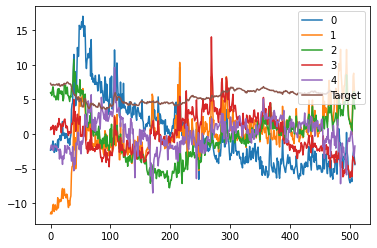

In [37]:
principalDf.plot()

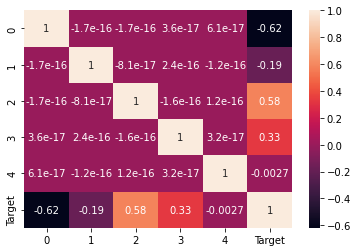

In [38]:
# correlation plot with target and pca
corrMatrix = principalDf.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [39]:
df_pca_train = principalDf[30:]
df_pca_test =  principalDf[:30]

In [40]:
# building linear model
predictors = df_pca_train[[0,1,2,3,4]]
predictors_cons = sm.add_constant(predictors)

fitted_linear = sm.OLS(df_pca_train['Target'], predictors_cons).fit()

fitted_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     476.0
Date:                Sun, 03 Jul 2022   Prob (F-statistic):          3.40e-182
Time:                        20:02:38   Log-Likelihood:                -174.21
No. Observations:                 480   AIC:                             360.4
Df Residuals:                     474   BIC:                             385.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4281      0.017    320.514      0.000       5.395       5.461
0             -0.1165      0.003    -36.842      0.000      -0.123      -0.110
1             -0.0340      0.006     -5.516      0.000      -0.046      -0.022
2              0.1459      0.006     26.416      0.000       0.135       0.157
3              0.1045      0.005     19.027      0.000       0.094       0.115
4              0.0081      0.008      1.065      0.287      -0.007       0.023
==============================================================================
Omnibus:                        2.881   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.680
Skew:                           0.141   Prob(JB):                        0.262
Kurtosis:                       3.234   Cond. No.                         5.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Generates a fitted forecast of each pca and then saves each one into a list

In [41]:
forecast_list = []
for col in df_pca_train.columns:
    forecast_list.append(pm.auto_arima(df_pca_train[col], seasonal = False))

In [42]:
df_step_ahead_forecast = pd.DataFrame()

# for loops goes through each predictor column and then gets a one step ahead forecast by slowing updating the fitted models
# with one more observation using a for loop. The forecasted values are then saved to a dataframe
for col in df_pca_test.columns[:-1]:
    
    test_forecast = []
    
    forecast_model_col = forecast_list[col]
    
    for i in range(len(df_pca_test), 0, -1):
        
        tmp_forecast_model = forecast_model_col
        
        if (i == 30):
        
            test_forecast.append(tmp_forecast_model.predict(n_periods = 1)[0])
        else:
            
            tmp_forecast_model.update(df_pca_test[col][i:])

            test_forecast.append(tmp_forecast_model.predict(n_periods = 1)[0])
    
    df_step_ahead_forecast[col] = test_forecast

Gets predicted values from the linear model using the forecasted predictor values

In [43]:
df_new_forecast = sm.add_constant(df_step_ahead_forecast)

pred_lm_forecast = fitted_linear.predict(df_new_forecast)

In [44]:
# mae for forecasted variables as predictors of the closed amount.
# 2 dollars is a pretty decent mae 
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)))

3.0384205317944795

In [45]:
np.std(special.inv_boxcox(df_pca_test['Target'], fitted_lambda))

1.0029007373059866

In [46]:
# mape for the forecasted new dataset using one step ahead forecasts
np.mean(np.abs(special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)) / special.inv_boxcox(df_pca_test['Target'], fitted_lambda))

0.107296541601673

In [47]:
# possible bias in these models... It is always lower than the actual
special.inv_boxcox(pred_lm_forecast, fitted_lambda) - special.inv_boxcox(df_pca_test['Target'], fitted_lambda)

0    -9.654521
1    -4.645040
2    -3.493494
3    -2.634215
4    -2.813574
5    -2.739031
6    -2.015672
7    -2.050443
8    -2.200284
9    -2.271502
10   -2.941370
11   -3.116177
12   -1.925059
13   -2.041266
14   -3.521774
15   -2.363030
16   -0.828970
17   -1.617540
18   -1.512893
19   -2.428593
20   -1.546771
21   -1.862991
22   -3.130724
23   -3.798636
24   -2.997749
25   -3.073101
26   -3.478886
27   -4.525588
28   -5.153476
29   -4.770245
dtype: float64

## Technical analysis

In [48]:
# inport necessary libraries
import talib as tb
import random

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [49]:
macd, macdsignal, macdhist = tb.MACD(df_apple['close'], fastperiod=12, slowperiod=26, signalperiod=9)

In [50]:
# creates a macD dataframe using talib and then merges original dataset onto it
df_mac = pd.DataFrame({'macd': macd, 'macdsignal': macdsignal, 'macdhist':macdhist})

df_mac = df_mac.merge(df_apple, left_index=True, right_index=True)
df_mac['MOM'] = tb.MOM(df_apple['close'], timeperiod=5)

for i in range(2, 13):
    df_mac['MA_' + str(i)] = tb.SMA(df_apple['close'], timeperiod=i)

In [51]:
df_mac

,macd,macdsignal,macdhist,open,high,low,close,volume,trade_count,vwap,...,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_9,MA_10,MA_11,MA_12
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-09-01 04:00:00+00:00,NaN,NaN,NaN,132.91,134.800,130.5300,134.18,152880540,1494300,132.851768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-02 04:00:00+00:00,NaN,NaN,NaN,137.58,137.980,127.0000,131.40,200393336,1843498,131.616730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-03 04:00:00+00:00,NaN,NaN,NaN,126.97,128.840,120.5000,120.88,257604126,2360769,123.526182,...,128.820000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-04 04:00:00+00:00,NaN,NaN,NaN,120.00,123.700,110.8900,120.96,332632509,2967070,117.943903,...,124.413333,126.8550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08 04:00:00+00:00,NaN,NaN,NaN,113.74,118.990,112.6800,112.82,231598461,2003683,115.392545,...,118.220000,121.5150,124.048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27 04:00:00+00:00,-3.080837,-4.017295,0.936458,142.70,143.490,140.9650,141.66,73357944,516181,142.026287,...,140.530000,139.2350,138.562,137.395000,136.347143,136.23250,135.846667,135.450,135.602727,136.189167
2022-06-28 04:00:00+00:00,-2.940865,-3.802009,0.861144,142.10,143.422,137.3250,137.44,67315336,546241,139.375156,...,140.253333,139.7575,138.876,138.375000,137.401429,136.48375,136.366667,136.006,135.630909,135.755833
2022-06-29 04:00:00+00:00,-2.654894,-3.572586,0.917691,137.44,140.670,136.6700,139.23,66354959,572556,139.273624,...,139.443333,139.9975,139.652,138.935000,138.497143,137.63000,136.788889,136.653,136.299091,135.930833


In [52]:
# shisfts close back one to get tomorrow's close price
df_mac['next_day_close'] = df_mac['close'].shift(periods=-1, axis="index")

In [53]:
# creates a boolean columns on if the next day is higher than the previous
df_mac['higher_than_yesterday'] = np.where(df_mac['next_day_close'] > df_mac['close'], 1, 0)

In [54]:
df_mac_nona = df_mac.loc[(~df_mac['macdhist'].isna()) & ~(df_mac['next_day_close'].isna()),]

In [55]:
random.seed(10)

# define the model
random_forest_macd = RandomForestClassifier()
# evaluate the model
random_forest_macd.fit(df_mac_nona[['MA_10', 'macdhist']], df_mac_nona['higher_than_yesterday'])

RandomForestClassifier()

completely random

In [56]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(random_forest_macd, df_mac_nona[['close','macdhist']], df_mac_nona['higher_than_yesterday'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.512 (0.079)


In [57]:
# let's build no model and just get the percentage of being above the certain shift forwards. Use difference between the
# macd to use a velocity... maybe the faster the machhist the more likely the closing price will be maintain a trend.

In [58]:
from statsmodels.tsa.stattools import adfuller

In [59]:
# creates a boolean columns on if the next day is higher than the previous
df_mac['macd_positive'] = np.where(df_mac['MA_5'] > 0, 1, 0)

In [60]:
df_mac.groupby(by = ["macd_positive"]).agg({'close':['mean','std']})

close           
                    mean        std
macd_positive                      
0              126.85500   6.946565
1              142.12125  18.910146

# augmented dickey fuller test function
if we do not reject null hypothesis implies that the data is not stationary

In [61]:
# takes in time series data vector
# prints out test statistics and returns the p-value
def adf_test(ts_array, print_test_stats):
    dickeyfuller = adfuller(ts_array)
    if (print_test_stats):
        print('ADF Statistic: %f' % dickeyfuller[0])
        print('p-value: %f' % dickeyfuller[1])
        print('Critical Values:')
        for key, value in dickeyfuller[4].items():
            print('\t%s: %.3f' % (key, value))
    else:
        return(dickeyfuller[1])

In [62]:
adf_test(df_mac['close'], False)

0.4841947243817831

making stationary value

In [63]:
df_mac['close_stationary'] = df_mac['close'] - df_mac['close'].shift(periods=1, axis="index")

In [64]:
# retesting
adf_test(df_mac['close_stationary'].dropna(), True)

ADF Statistic: -22.097675
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [65]:
df_mac.groupby(by = ["macd_positive"]).agg({'close_stationary':['mean','std']})

close_stationary          
                          mean       std
macd_positive                           
0                    -4.406667  5.484025
1                     0.039236  2.735764

# Decision Trees
And giving specific instructions of what to use, so visualization is "easy"
First create df with common indicators

In [66]:
from sklearn import tree
import graphviz
import itertools

In [67]:
# ripped off my earlier code
macd, macdsignal, macdhist = tb.MACD(df_apple['close'], fastperiod=12, slowperiod=26, signalperiod=9)
# creates a macD dataframe using talib and then merges original dataset onto it
df_mac = pd.DataFrame({'macd': macd, 'macdsignal': macdsignal, 'macdhist':macdhist})

df_mac = df_mac.merge(df_apple, left_index=True, right_index=True)
df_mac['MOM'] = tb.MOM(df_apple['close'], timeperiod=5)
df_mac['SAR'] = tb.SAR(df_apple['high'], df_apple['low'])

# create stationary time series
if (adf_test(df_mac['close'], False) > 0.05):
    df_mac['close'] = df_mac['close'] - df_mac['close'].shift(periods=1, axis="index")
    
for i in [21]:
    df_mac['MA_' + str(i)] = tb.SMA(df_mac['close'], timeperiod=i)

for i in [21]:
    df_mac['EMA_' + str(i)] = tb.EMA(df_mac['close'], timeperiod=i)

df_mac['std'] = df_mac['close'].rolling(30).std()

In [68]:
df_mac = df_mac.dropna(axis = 0, how = 'any')

## Fitting that tree with small number of features and nodes

fits a regression tree using very restictive options to create thresholds, easy to implement

In [69]:
df_mac.loc[df_mac['close'] < -150]

,macd,macdsignal,macdhist,open,high,low,close,volume,trade_count,vwap,MOM,SAR,MA_21,EMA_21,std
timestamp,,,,,,,,,,,,,,,


In [70]:
mac_tree = tree.DecisionTreeRegressor(criterion = "absolute_error", max_features = 3, max_leaf_nodes = 3)
mac_tree = mac_tree.fit(X = df_mac.drop(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], axis = 1),\
                        y = df_mac['close'])

### plots the fitted calssification tree

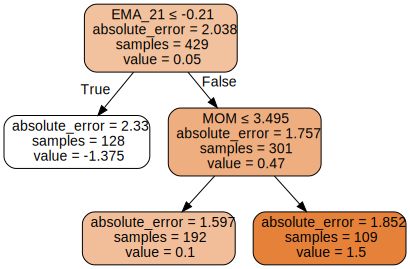

In [71]:
dot_data = tree.export_graphviz(mac_tree, out_file=None, \
                                feature_names=df_mac.drop(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], axis = 1).columns,\
                                filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

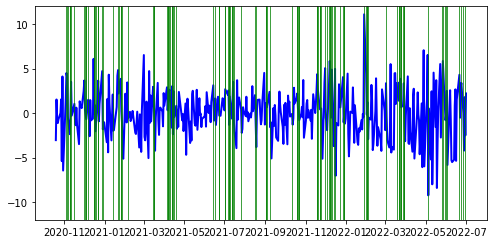

In [79]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = df_mac.index
y = df_mac['close']
plt.plot(x, y, c='blue', lw=2)
plt.ylim([-12, 12])
plt.vlines((df_mac.loc[df_mac['MOM'] > 3.495].index), ymin = -12, ymax = 12, color='green', alpha=0.75, lw=1)
plt.show()


In [73]:
# produces list of regression tree with thresholds
saved_features = zip(df_mac.drop(['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap'], axis = 1).columns[mac_tree.tree_.feature],\
                     mac_tree.tree_.impurity,\
                     mac_tree.tree_.threshold,\
                     mac_tree.tree_.children_left,\
                     mac_tree.tree_.children_right,\
                     list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(mac_tree.tree_.value.tolist())))))

list(saved_features)

[('EMA_21',
  2.0382871794871784,
  -0.21006594598293304,
  1,
  2,
  0.05000000000001137),
 ('EMA_21', 2.330195312500001, -2.0, -1, -1, -1.375000000000007),
 ('MOM', 1.7569109634551479, 3.4950000047683716, 3, 4, 0.46999999999999886),
 ('EMA_21', 1.597343750000001, -2.0, -1, -1, 0.09999999999999432),
 ('EMA_21', 1.8519284403669716, -2.0, -1, -1, 1.5)]

### creating df stock indexes by cap size and sector

In [74]:
# Communication stocks
com_stock = ['GOOGL', 'Large',\
 'META', 'Large',\
 'VZ', 'Large',\
 'DIS', 'Large',\
 'CMCSA', 'Large',\
 'TMUS', 'Large',\
 'T', 'Large',\
 'NFLX', 'Large',\
 'CHTR', 'Large',\
 'NTES', 'Large']

# Consumer Discretionary
consumer_dis_stock = ['AMZN', 'Large',\
                 'TSLA', 'Large',\
                 'LVMHF', 'Large',\
                 'HD', 'Large',\
                 'TM', 'Large',\
                 'NKE', 'Large',\
                 'MCD', 'Large',\
                 'VWAGY', 'Large',\
                 'HESAY', 'Large',\
                 'LOW', 'Large',\
                 'APTV', 'Mid',\
                 'SCI', 'Mid',\
                 'WSM', 'Mid',\
                 'GME', 'Mid',\
                 'FIVE', 'Mid',\
                 'LAD', 'Mid',\
                 'DHI', 'Mid',\
                 'LEN', 'Mid',\
                 'ORLY', 'Mid',\
                 'EBAY', 'Small',\
                 'FL', 'Mid',\
                 'COUR', 'Small']
# Consumer Staples
consumer_sta_stocks = ['WMT', 'Large',\
                       'PG', 'Large',\
                       'NSRGY', 'Large',\
                       'KO', 'Large',\
                       'COST', 'Large',\
                       'PEP', 'Large',\
                       'LRLCY', 'Large',\
                       'PM', 'Large',\
                       'UL', 'Large',\
                       'TGT', 'Large']
# energy 
energy_stocks = ['XOM', 'Large',\
                 'CVX', 'Large',\
                 'RYDAF', 'Large',\
                 'TTE', 'Large',\
                 'COP', 'Large',\
                 'EQNR', 'Large',\
                 'BP', 'Large',\
                 'PTR', 'Large',\
                 'ENB', 'Large',\
                 'PBR', 'Large',\
                 'XOM', 'Large']
# Financial  
finance_stocks = ['BRK.A', 'Large',\
                  'V', 'Large',\
                  'JPM', 'Large',\
                  'MA', 'Large',\
                  'BAC', 'Large',\
                  'IDCBY', 'Large',\
                  'CICHY', 'Large',\
                  'WFC', 'Large',\
                  'MS', 'Large',\
                  'C', 'Large',\
                  'WFC', 'Large',\
                  'BFH', 'Mid']
# health  
health_stocks = ['JNJ', 'Large',\
                 'UNH', 'Large',\
                 'PFE', 'Large',\
                 'LLY', 'Large',\
                 'RHHBY', 'Large',\
                 'NVO', 'Large',\
                 'MRK', 'Large',\
                 'TMO', 'Large',\
                 'DHR', 'Large',\
                 'ABT', 'Large',\
                 'OPRX', 'Small',\
                 'GBT', 'Small']
# Industrial   
indus_stocks = ['UPS', 'Large',\
                 'RTX', 'Large',\
                 'UNP', 'Large',\
                 'HON', 'Large',\
                 'CAT', 'Large',\
                 'DE', 'Large',\
                 'SIEGY', 'Large',\
                 'GE', 'Large',\
                 'BA', 'Large',\
                 'X', 'Mid']
# Materials   
mater_stocks = ['BHP', 'Large',\
                 'LIN', 'Large',\
                 'RIO', 'Large',\
                 'AIQUY', 'Large',\
                 'VALE', 'Large',\
                 'GLNCY', 'Large',\
                 'SHW', 'Large',\
                 'SHECY', 'Large',\
                 'ECL', 'Large']
# Real Estate   
property_stocks = ['AMT', 'Large',\
                     'PLD', 'Large',\
                     'CCI', 'Large',\
                     'DLR', 'Large',\
                     'EQIX', 'Large',\
                     'SPG', 'Large',\
                     'PSA', 'Large',\
                     'O', 'Large',\
                     'WELL', 'Large', \
                     'SBAC', 'Large']
# Technology    
tech_stocks = ['AAPL', 'Large',\
                 'MSFT', 'Large',\
                 'TSM', 'Large',\
                 'NVDA', 'Large',\
                 'TCEHY', 'Large',\
                 '005930.KS', 'Large',\
                 'BABA', 'Large',\
                 'ASML', 'Large',\
                  'FOUR', 'Small',\
                  'FLYW', 'Small',\
                  'AMBA', 'Mid']
# Utilities    
util_stocks = ['NEE', 'Large',\
                 'DUK', 'Large',\
                 'SO', 'Large',\
                 'D', 'Large',\
                 'AEP', 'Large',\
                 'SRE', 'Large',\
                 'EXC', 'Large',\
                 'XEL', 'Large',\
                 'PEG', 'Large',\
                  'FLNC', 'Small',\
                  'NOVA', 'Small']
# Defense 
def_stocks = ['GD', 'Large',\
              'LMT', 'Large',\
              'RTX', 'Large']

In [75]:
# multi list with hand created index lists
list_sector_index = [com_stock, consumer_dis_stock, consumer_sta_stocks, energy_stocks, finance_stocks, health_stocks, \
              indus_stocks, mater_stocks, property_stocks, tech_stocks, util_stocks, def_stocks]
# list of sectors
list_of_sectors = ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financial', 'Healthcare',\
                   'Industrial', 'Materials', 'Real Estate', 'Technology', 'Utilities', 'Defense']
#  empty list to append
arrayofsec = []
# creates repeats the sector name the number of times the value occurs 
for i, string in enumerate(list_of_sectors):
    arrayofsec.append(list(itertools.chain(np.repeat(string, len(list_sector_index[i][1::2])))))

In [76]:
# creates function to flatten nested lists
def flatten(xss):
    return [x for xs in xss for x in xs]
# flattens arrayofsec
flat_sector = flatten(arrayofsec)

In [77]:
df_index = pd.DataFrame({'Index': flatten(list_sector_index)[::2], 'Cap size': flatten(list_sector_index)[1::2], 'Sector': flat_sector})

In [78]:
df_index.tail(10)

,Index,Cap size,Sector
121,AEP,Large,Utilities
122,SRE,Large,Utilities
123,EXC,Large,Utilities
124,XEL,Large,Utilities
125,PEG,Large,Utilities
126,FLNC,Small,Utilities
127,NOVA,Small,Utilities
128,GD,Large,Defense
129,LMT,Large,Defense
130,RTX,Large,Defense
